### Importing necessarily libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers.normalization import batch_normalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.decomposition import PCA

### Importing and visualizing some samples from our dataset

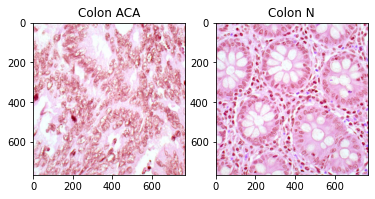

In [ ]:
colon_aca = "/content/drive/My Drive/lung_colon_image_set/colon_image_sets/colon_aca/"

plt.subplot(121)
img = cv2.imread(colon_aca + os.listdir(colon_aca)[0])
plt.title('Colon ACA')
plt.imshow(img)

plt.subplot(122)
colon_n = "/content/drive/My Drive/lung_colon_image_set/colon_image_sets/colon_n/"
img = cv2.imread(colon_n + os.listdir(colon_n)[0])
plt.title('Colon N')
plt.imshow(img)
plt.show()

### Image data generators for generating images

In [ ]:
data_dir = "/content/drive/My Drive/lung_colon_image_set/colon_image_sets/"
SIZE_X = SIZE_Y = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.3)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12,
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = (SIZE_X,SIZE_Y),
                                          color_mode="rgb",
                                          batch_size = 12,
                                          shuffle = False,
                                          subset='validation',
                                          seed = 42)

Found 7000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


### Adding some callbacks and metrics

In [ ]:
def fit_model(model, train_it, validate_it, epochs = 50):
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

  for layer in model.layers:
    layer.trainable = False

  flat1 = Flatten()(model.layers[-1].output)
  output = Dense(len(train_it.class_indices), activation='softmax')(flat1)

  model = Model(inputs=model.inputs, outputs=output)
  print(model.summary())

  model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

  history = model.fit(train_it, validation_data=validate_it, epochs=epochs, verbose=1, callbacks=[es])
  return model

In [ ]:
def get_accuracy_metrics(model, train_it, validate_it):
  y_val = validate_it.classes

  val_pred_proba = model.predict(validate_it)

  val_pred_proba, predicted_proba, y_val, y_test = train_test_split(val_pred_proba, y_val, test_size = 0.5, shuffle = True)

  val_pred = np.argmax(val_pred_proba, axis = 1)
  predicted = np.argmax(predicted_proba, axis = 1)

  print("Train accuracy Score------------>")
  print("{0:.3f}".format(accuracy_score(train_it.classes, np.argmax(model.predict(train_it), axis = 1))*100), "%")

  print("Val accuracy Score---------->")
  print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")

  print("Test accuracy Score---------->")
  print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")

  print("F1 Score---------->")
  print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")

  print("Cohen Kappa Score---------->")
  print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")

  print("ROC AUC Score---------->")
  print("{0:.3f}".format(roc_auc_score(y_test, predicted_proba[:, 1])*100), "%")

  print("Recall---------->")
  print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")

  print("Precision---------->")
  print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")

  cf_matrix_test = confusion_matrix(y_test, predicted)
  cf_matrix_val = confusion_matrix(y_val, val_pred)

  plt.figure(figsize = (12, 6))
  plt.subplot(121)
  sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
  plt.title("Val Confusion matrix")

  plt.subplot(122)
  sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
  plt.title("Test Confusion matrix")

  plt.show()

In [ ]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 4.4 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=abc3b928c457555aeec3671774ad66b3e98e724f86ccc1e5e8a05cdefeebf694
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


### Applying deep learning algorithms

VGG 16

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')
model = fit_model(model, train_it, validate_it)

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

Train accuracy Score------------>
99.629 %
Val accuracy Score---------->
99.267 %
Test accuracy Score---------->
98.667 %
F1 Score---------->
98.667 %
Cohen Kappa Score---------->
97.334 %
ROC AUC Score---------->
99.918 %
Recall---------->
98.667 %
Precision---------->
98.702 %


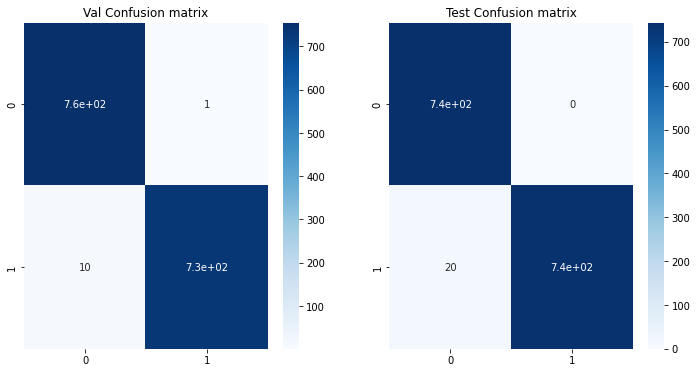

In [ ]:
get_accuracy_metrics(model, train_it, validate_it)

VGG19

In [ ]:
from keras.applications.vgg19 import VGG19 
model = VGG19(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')
model = fit_model(model, train_it, validate_it)

80150528/80134624 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

Train accuracy Score------------>
99.886 %
Val accuracy Score---------->
99.333 %
Test accuracy Score---------->
99.467 %
F1 Score---------->
99.467 %
Cohen Kappa Score---------->
98.932 %
ROC AUC Score---------->
99.649 %
Recall---------->
99.467 %
Precision---------->
99.470 %


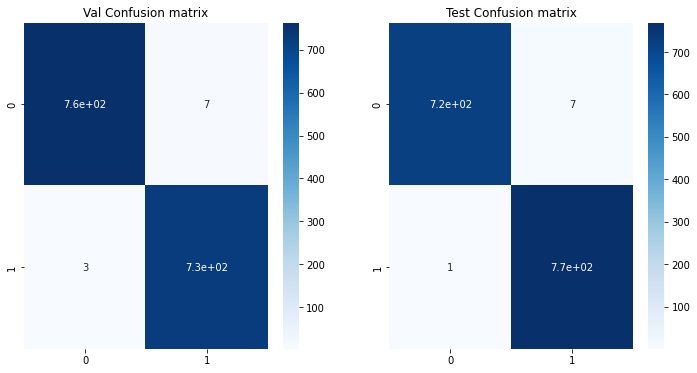

In [ ]:
get_accuracy_metrics(model, train_it, validate_it)

EFFICIENT NET V2B3

In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2B3 
model = EfficientNetV2B3(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')
model = fit_model(model, train_it, validate_it)

52617216/52606240 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)          

In [ ]:
get_accuracy_metrics(model, train_it, validate_it)